In [5]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from NERD import GenRD
import models
from dataloaders import MNISTDataModule, FMNISTDataModule, GaussianDataModule
import GaussianSource
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
def calc_RD(loader, model, D):
    """Evaluates R(D) for trained Q_Y at distortion=D."""
    Rate = 0
    Dist = 0
    model.to(device)
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
            z = torch.randn(x.shape[0], model.latent_dim).to(device)
            y = model.generator(z).to(device)
#             print(x.device, y.device)
            C = model._squared_distances(x,y)
            beta = model.inner_max(C)
            # print(beta)
            eps = 1e-14
            R = beta*D - torch.mean(torch.log(torch.mean(torch.exp(beta*C), dim=1)+eps))
            # D = torch.mean(C*torch.exp(beta*C) / (torch.mean(torch.exp(beta*C), dim=1)[:,None])+1e-14)
            D = torch.mean(C*torch.exp(beta*C) / ((torch.mean(torch.exp(beta*C), dim=1)+eps)[:,None]))
            Rate += R.item()
            Dist += D.item()
    return (Rate/np.log(2))/len(loader), Dist/len(loader), beta

def RD_curve(Ds, loader, generator, data_name="MNIST"):
    """Evaluates R(D) at multiple distortions in list Ds."""
    rates_true_rd = []
    dists_true_rd = []
    for D in Ds:
        model = GenRD(D=D, data_name=data_name, generator=generator)
        # model.generator = models.Generator(img_size=(32,32,1), latent_dim=100, dim=64)
        checkpoint = torch.load(f'trained/trained_{data_name}/NERD_{data_name}_D{D:.3f}.pt')
        model.load_state_dict(checkpoint)
        model.to(device)
        r, d, beta = calc_RD(loader, model, D)
        print(f'r={r}, d_alt={d}, d={D}, beta={beta}')
        rates_true_rd.append(r)
        dists_true_rd.append(d)
    return np.array(rates_true_rd), np.array(dists_true_rd)


1
r=15.78235751274581, d_alt=0.9999999642372132, d=1, beta=-10.446453094960102
2
r=6.886932708354448, d_alt=1.9999999523162841, d=2, beta=-2.5426697739746733
3
r=4.4450957893523935, d_alt=3.0, d=3, beta=-1.143531204212782
4
r=3.0570772664465533, d_alt=4.0, d=4, beta=-0.7552762339200763
5
r=2.117945088319842, d_alt=4.999999713897705, d=5, beta=-0.5361503372387564
6
r=1.4413539201775352, d_alt=5.9999998092651365, d=6, beta=-0.3927382836608746
7
r=0.929116802850246, d_alt=7.0, d=7, beta=-0.29892131784716036
8
r=0.544975837935124, d_alt=7.9999998092651365, d=8, beta=-0.21771658310857914


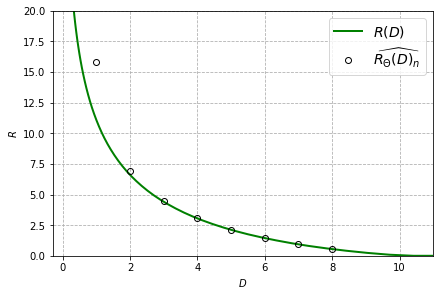

In [10]:
"""Gaussian data."""
m = 20
r = 0.25

dm = GaussianDataModule(10000, m, r)
generator= models.Decoder_FC(m, 100)
loader = dm.train_dataloader()
Ds = [1, 2, 3, 4, 5, 6, 7, 8]
rates, dists = RD_curve(Ds, loader, generator, 'Gaussian')

# Get true rate-distortion curve

sigmas = 2*np.exp(-r*np.arange(m))
D_max =sum(sigmas**2)
DD = np.geomspace(0.01, 1.1*D_max, 100)
RR = []
for D in DD:
    RR.append(GaussianSource.rd_gaussian(D, sigmas))
DD = np.array(DD)
RR = np.array(RR)

# plot 
plt.figure(1, constrained_layout=True)
plt.plot(DD, RR, '-', color='g', linewidth=2, label=r'$R(D)$')
plt.plot(dists, rates, 'o', color='k', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none')
plt.xlabel('$D$')
plt.ylabel('$R$')
plt.grid(linestyle='dashed')
plt.legend(fontsize=14)
plt.xlim([-0.3, 11])
plt.ylim([0, 20])
plt.show()

In [ ]:
"""MNIST data"""
dm = MNISTDataModule(10000)
generator = models.Generator(img_size=(32,32,1), latent_dim=100, dim=64)
loader = dm.train_dataloader()
Ds = [10, 20, 30, 40, 50]
rates, dists = RD_curve(Ds, loader, generator, 'MNIST')

In [25]:
img_size = (32, 32, 4)
dLpairs= [(4,4), (5, 4), (4,8),(5,8), (6,8), (7,8), (9,8), (10,8),(12,8), (15,8)]
d_DNN_block = []
r_DNN_block = []
for pair in dLpairs:
    latent_dim, L = pair
#     netG = layers_compress.Generator(img_size=img_size, latent_dim=latent_dim, dim=64).to(device)
#     netE = layers_compress.Encoder(img_size, latent_dim, dim=64).to(device)
#     netQ = layers_compress.Quantizer(np.linspace(-1., 1., L))
    saved = torch.load(f'../trained_compressors_FMNIST/trained_block4/ae_c_d{latent_dim}L{L}.pt')
    model_ae = layers_compress.AutoencoderQ(saved['netE'], saved['netG'], saved['netQ']).to(device)
    
    dist = 0
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
            x = torch.reshape(x, (int(x.shape[0]/4), 1, 64, 64))
#             print(x.shape)
            xhat = model_ae(x)
            dist += torch.mean(torch.linalg.norm(x-xhat, dim=(1,2,3))**2)/4
            # dist += F.mse_loss(x, xhat)*img_size[0]*img_size[1]
    dist = dist / len(loader)
    d_DNN_block.append(dist)
    r_DNN_block.append(latent_dim * np.log2(L) / 4)
d_DNN_block = [d.cpu().numpy().item() for d in d_DNN_block]
I = np.argsort(r_DNN_block)
r_DNN_block = np.array(r_DNN_block)[I]
d_DNN_block = np.array(d_DNN_block)[I]

In [69]:
rd = np.array(rates_true_rd)
rd_upper = rd + np.log2(rd + 1) + 5

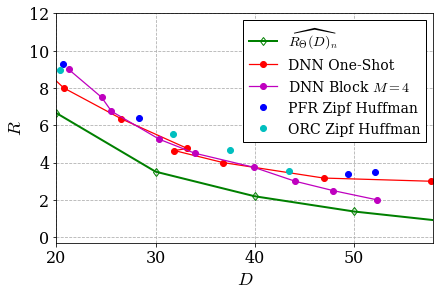

In [29]:
plt.figure(1, constrained_layout=True)
# rates = [r.numpy() for r in rates]
# dists = [d.cpu().numpy() for d in dists]
# plt.plot(dists_rd_sinkhorn1k, rates_rd_sinkhorn1k, '--', color='b', label='RD-Sinkhorn', linewidth=2)
# plt.plot(dists_true_rd1k, rates_true_rd1k, '-o', color='g', label='True RD', fillstyle='none', linewidth=2)
plt.plot(DD, rates_true_rd, '-d', color='g', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none', linewidth=2)
# plt.plot(DD, rd_upper, '--', color='k', linewidth=2, label=r'$\widehat{R_\Theta(D)}_n+\log \left(\widehat{R_\Theta(D)}_n+1 \right)+5$')
# plt.plot(dists_BA10k, rates_BA10k, '--<', color='c', label=r'BA $n=10k$ $\mathcal{Y}=\mathcal{X}$', fillstyle='none', linewidth=2)
# plt.plot(dists_BA1k, rates_BA1k, '--<', color='m', label=r'BA $n=1k$ $\mathcal{Y}=\mathcal{X}$', fillstyle='none', linewidth=2)
# plt.plot(D_SLB, R_SLB) 
# plt.plot(dists_rd_sinkhorn100k[4:], rates_rd_sinkhorn100k[4:], '--', color='b', label='RD-Sinkhorn', linewidth=2)
# plt.plot(dists_true_rd10k, rates_true_rd10k, '-', color='g', label='True RD', fillstyle='none', linewidth=2)
plt.plot(d_DNN[:-1], r_DNN[:-1], '-o', color='r',label='DNN One-Shot')
plt.plot(d_DNN_block[:-1], r_DNN_block[:-1], '-o', color='m',label=r'DNN Block $M=4$')
plt.plot(dists_PFR[2:], rates_PFR_zipf[2:], 'o', color='b', label='PFR Zipf Huffman')
# plt.fill_between(dists_PFR[2:], np.array(rates_PFR_ent[2:]), np.array(rates_PFR_ent[2:])+1, color='y',alpha=0.5, label='PFR Hist. Entropy')
plt.plot(dists_ORD[2:], np.array(rates_ORD_zipf)[2:]-0.2, 'o', color='c', label='ORC Zipf Huffman')
# plt.fill_between(dists_ORD[2:], np.array(rates_ORD_ent[2:]), np.array(rates_ORD_ent[2:])+1, color='y',alpha=0.5, label='ORD Hist. Entropy')
# plt.plot(DD[2:], rates_PFR_UB[2:], '--',color='k', label=r'$R(D)+\log(R(D)+1)+4$',linewidth=2)
# plt.plot(rates_ba, dists_ba, '-*', label='Blahut-Arimoto')
plt.ylabel(r'$R$', fontsize=18)
plt.xlabel(r'$D$', fontsize=18)
plt.legend(fontsize=14)
plt.grid(linestyle='dashed')
plt.xlim([20, 58])
plt.ylim([-0.3, 12])
# plt.savefig('plots/block_DNN_fmnist.pdf')
# plt.savefig('plots/PFR_ORC_fmnist.pdf')

In [8]:
rates_BA10k=[0.001154811183555729, 1.9168113093427268, 2.3070905070497933, 2.6680041830699874, 3.006009769995256, 3.378797988144273, 3.7831336718716586, 4.208297486514436, 5.028956732664948, 5.430797980024219, 7.687843255499444, 8.374127641016619, 10.709421582981404]
dists_BA10k=[95.94007873535156, 49.91059875488281, 44.968971252441406, 41.111473083496094, 37.98060607910156, 34.93855667114258, 31.98761749267578, 29.17880630493164, 24.426273345947266, 22.36202621459961, 13.017748832702637, 10.75025463104248, 4.416116714477539]
rates_BA1k=[0.0015880471537297641, 2.07492562320526, 2.5783276133958952, 3.114054430746798, 3.625029676968177, 4.153418166589415, 4.672015683897033, 5.222491905368582, 6.242446711130727, 6.683016043707191, 8.492245325629197]
dists_BA1k=[98.53021240234375, 48.262733459472656, 41.921424865722656, 36.19157409667969, 31.46291160583496, 27.148927688598633, 23.364120483398438, 19.728363037109375, 13.809402465820312, 11.544965744018555, 3.892223358154297]

rates_ORD_zipf=[12.863, 12.7794, 12.1686, 11.336, 10.4538, 9.1702, 5.7436, 4.8696, 3.7678, 3.3212, 2.1028]
rates_ORD_ent=[9.046064119413295, 9.955915763578384, 9.652874043086282, 9.315929154672101, 8.648509501630947, 7.641361072440185, 4.366829881950098, 3.51482544987007, 2.8351332780638416, 1.742171546936059, 1.1400971294459434]
rates_PFR_zipf=[13.5494, 13.0302, 12.3496, 11.715, 10.3984, 9.2654, 6.3668, 3.4124, 3.4904, 2.8366, 2.5724]
rates_PFR_ent=[9.451881696844083, 10.153464564149957, 9.731071583397629, 9.495514893710412, 8.612998220189107, 7.568671165237488, 5.030745491486183, 2.3547068503640194, 2.116846352650545, 1.4716532959190736, 1.7546141997967672]
rates_PFR_UB=[38.39741105726004, 26.374809621403827, 23.066138101678327, 19.419513156840672, 16.912651867266117, 14.869231005157964, 10.751769802095154, 8.859058374527436, 7.6484621557032995, 6.655854209356528, 5.788735875027822]

dists_PFR=[39.03316879272461, 19.389127731323242, 18.184986114501953, 17.603622436523438, 19.0567626953125, 20.685869216918945, 28.341543197631836, 49.431758880615234, 52.12149429321289, 64.15755462646484, 64.32928466796875]
dists_ORD=[39.02774429321289, 19.500839233398438, 18.341089248657227, 17.930566787719727, 18.895793914794922, 20.341821670532227, 31.796836853027344, 37.52955627441406, 43.42338562011719, 59.02454376220703, 66.84874725341797]


# rates_ORD_zipf=[13.7556, 12.744, 11.4398, 11.0868, 10.5626, 9.6266, 6.3718, 4.3846, 3.7964, 3.2828, 2.3582]
# rates_ORD_ent=[9.188461749513822, 9.81709457526625, 9.223436201249061, 9.174562451785546, 8.713024938850452, 8.02588323513092, 5.002476635380168, 3.153710299728413, 2.7092503548767204, 2.12453307630403, 1.148337214225053]
# rates_PFR_zipf=[14.4634, 12.5932, 11.5862, 11.34, 10.1536, 9.7058, 5.1002, 5.6046, 3.1552, 3.1554, 2.0604]
# rates_PFR_ent=[9.471779884155396, 9.70539838617114, 9.255078732812592, 9.314633578012055, 8.545198313402743, 8.042647528244517, 4.092739231907118, 4.1294764499044465, 1.9079937380668446, 2.0924676242025413, 1.2136924584305298]
# rates_PFR_UB=[38.41013344157902, 27.207111929991235, 23.002217330179516, 19.340824101216963, 16.759283859196607, 14.840050900799381, 10.71014184193638, 8.89432179072439, 7.667075977872063, 6.69455683751373, 5.786641485280881]

# dists_PFR=[36.82038497924805, 22.16283416748047, 20.142192840576172, 18.075790405273438, 19.065664291381836, 20.24445343017578, 34.18143844604492, 34.06107711791992, 58.149925231933594, 52.00023651123047, 68.95347595214844]
# dists_ORD=[37.05769348144531, 22.156801223754883, 20.16756820678711, 18.16815185546875, 18.85334014892578, 20.04395866394043, 28.733549118041992, 39.02540969848633, 44.97407531738281, 56.04985046386719, 70.7909927368164]


__MNIST__

In [6]:
DD = [55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5]#, 2]
DD.reverse()
rates_true_rd = []
dists_true_rd = []
for D in DD:
    model = GenRD(D=D)
    checkpoint = torch.load(f'trained/trained_genRD_minmax/GenRD_trained_genRD_minmax_D{D:.3f}.pt')
    model.load_state_dict(checkpoint)
    model.to(device)
    r, d, beta = calc_RD(loader, model, D)
    print(f'r={r}, d_alt={d}, d={D}, beta={beta}')
    rates_true_rd.append(r)
    dists_true_rd.append(d)
# dists_true_rd = [d.cpu().numpy() for d in dists_true_rd]
# rates_true_rd = [d.cpu().numpy() for d in rates_true_rd]

r=28.653165419414613, d_alt=4.999999523162842, d=5, beta=-1.3899844302265603
r=20.13359342642452, d_alt=10.0, d=10, beta=-0.9834574176450818
r=13.9170204732202, d_alt=15.0, d=15, beta=-0.7227745292288811
r=9.567474667448044, d_alt=20.0, d=20, beta=-0.46174323338592416
r=7.033359837988008, d_alt=25.0, d=25, beta=-0.2818844604841806
r=5.297215615446058, d_alt=30.0, d=30, beta=-0.21054769992351532
r=3.9397180280721167, d_alt=35.000003814697266, d=35, beta=-0.1712112930529448
r=2.8093097725504443, d_alt=40.0, d=40, beta=-0.1454367314160987
r=1.8476804750713087, d_alt=44.999996185302734, d=45, beta=-0.12593502617174523
r=1.0225159713987944, d_alt=50.0, d=50, beta=-0.10949550183393061
r=0.3263246972613173, d_alt=54.999996185302734, d=55, beta=-0.09351715866065818


In [14]:
print(DD)

[55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5]


In [17]:
print(rates_true_rd)

[0.2768123149871826, 0.7088899612426758, 1.1890192031860352, 1.9514532089233398, 2.7233734130859375, 3.630601406097412, 5.146864891052246, 6.27536678314209, 8.789888381958008, 11.262533187866211, 18.111900329589844]


In [4]:
import layers_compress
img_size = (32, 32, 1)
dLpairs= [(2, 3), (2, 4), (2, 5), (2,6), (3,4), (4,4),(4,6), (4,8), (4,12), (6, 12), (5, 12), (7,12), (8,12), (9, 12), (10,12)]
d_DNN = []
r_DNN = []
for pair in dLpairs:
    latent_dim, L = pair
#     netG = layers_compress.Generator(img_size=img_size, latent_dim=latent_dim, dim=64).to(device)
#     netE = layers_compress.Encoder(img_size, latent_dim, dim=64).to(device)
#     netQ = layers_compress.Quantizer(np.linspace(-1., 1., L))
    saved = torch.load(f'../trained_compressors/ae_c_d{latent_dim}L{L}.pt')
    model_ae = layers_compress.AutoencoderQ(saved['netE'], saved['netG'], saved['netQ']).to(device)
    
    dist = 0
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
#             print(x.shape)
            xhat = model_ae(x)
            dist += F.mse_loss(x, xhat)*img_size[0]*img_size[1]
    dist = dist / len(loader)
    d_DNN.append(dist)
    r_DNN.append(latent_dim * np.log2(L))
d_DNN = [d.cpu().numpy().item() for d in d_DNN]
I = np.argsort(r_DNN)
r_DNN = np.array(r_DNN)[I]
d_DNN = np.array(d_DNN)[I]

In [5]:
img_size = (32, 32, 4)
dLpairs= [(4,4), (5, 4), (4,8),(5,8), (6,8), (7,8), (8,8), (9,8), (10,8),(12,8), (15,8)]
d_DNN_block = []
r_DNN_block = []
for pair in dLpairs:
    latent_dim, L = pair
#     netG = layers_compress.Generator(img_size=img_size, latent_dim=latent_dim, dim=64).to(device)
#     netE = layers_compress.Encoder(img_size, latent_dim, dim=64).to(device)
#     netQ = layers_compress.Quantizer(np.linspace(-1., 1., L))
    saved = torch.load(f'../trained_compressors/trained_block4/ae_c_d{latent_dim}L{L}.pt')
    model_ae = layers_compress.AutoencoderQ(saved['netE'], saved['netG'], saved['netQ']).to(device)
    
    dist = 0
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
            x = torch.reshape(x, (int(x.shape[0]/4), 1, 64, 64))
#             print(x.shape)
            xhat = model_ae(x)
            dist += torch.mean(torch.linalg.norm(x-xhat, dim=(1,2,3))**2)/4
            # dist += F.mse_loss(x, xhat)*img_size[0]*img_size[1]
    dist = dist / len(loader)
    d_DNN_block.append(dist)
    r_DNN_block.append(latent_dim * np.log2(L) / 4)
d_DNN_block = [d.cpu().numpy().item() for d in d_DNN_block]
I = np.argsort(r_DNN_block)
r_DNN_block = np.array(r_DNN_block)[I]
d_DNN_block = np.array(d_DNN_block)[I]

In [14]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth':1.25})
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = None
plt.rcParams['legend.edgecolor'] = 'inherit'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams["font.family"] = "serif"

In [10]:
r_UB = np.array(rates_true_rd)+np.log2(np.array(rates_true_rd)+1)+5

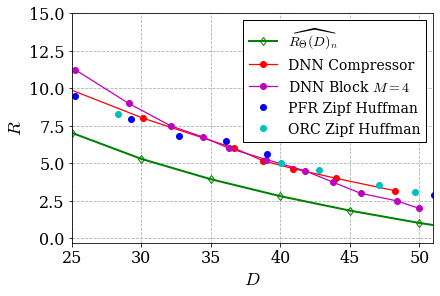

In [13]:
plt.figure(1, constrained_layout=True)
# rates = [r.numpy() for r in rates]
# dists = [d.cpu().numpy() for d in dists]
# plt.plot(dists_rd_sinkhorn1k, rates_rd_sinkhorn1k, '--', color='b', label='RD-Sinkhorn', linewidth=2)
# plt.plot(dists_true_rd1k, rates_true_rd1k, '-o', color='g', label='True RD', fillstyle='none', linewidth=2)
plt.plot(DD[:], rates_true_rd[:], '-d', color='g', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none', linewidth=2)
# plt.plot(DD, r_UB, '--', color='k', linewidth=2, label=r'$\widehat{R_\Theta(D)}_n+\log \left(\widehat{R_\Theta(D)}_n+1 \right)+5$')


# plt.plot(dists_YisX, rates_YisX, '--<', color='m', label=r'BA $n=60k$, $\mathcal{Y}=\mathcal{X}$', fillstyle='none', linewidth=2)
# plt.plot(dists_YisX10k, rates_YisX10k, '-->', color='c', label=r'BA $n=10k$, $\mathcal{Y}=\mathcal{X}$', fillstyle='none', linewidth=2)
# plt.plot(D_SLB, R_SLB) 
# plt.plot(dists_rd_sinkhorn100k[4:], rates_rd_sinkhorn100k[4:], '--', color='b', label='RD-Sinkhorn', linewidth=2)
# plt.plot(dists_true_rd10k, rates_true_rd10k, '-', color='g', label='True RD', fillstyle='none', linewidth=2)
plt.plot(d_DNN[:-1], r_DNN[:-1], '-o', color='r',label='DNN Compressor')
plt.plot(d_DNN_block[:], r_DNN_block[:], '-o', color='m',label=r'DNN Block $M=4$')


plt.plot(dists_PFR[:], rates_PFR_zipf[:], 'o', color='b', label='PFR Zipf Huffman')
# plt.fill_between(dists_PFR[2:], np.array(rates_PFR_ent[2:]), np.array(rates_PFR_ent[2:])+1, color='y',alpha=0.5, label='PFR Hist. Entropy')
plt.plot(dists_ORD[2:], rates_ORD_zipf[2:], 'o', color='c', label='ORC Zipf Huffman')
# plt.fill_between(dists_ORD[2:], np.array(rates_ORD_ent[2:]), np.array(rates_ORD_ent[2:])+1, color='y',alpha=0.5, label='ORD Hist. Entropy')

# plt.plot(DD[2:], r_UB[2:], '--',color='k', label=r'$R(D)+\log(R(D)+1)+4$',linewidth=2)
# plt.plot(dists_PFR[3:], np.array(rates_PFR_ent[3:])+1, '--', color='k', label='PFR Hist. Entropy')
# plt.plot(rates_ba, dists_ba, '-*', label='Blahut-Arimoto')
plt.ylabel(r'$R$', fontsize=18)
plt.xlabel(r'$D$', fontsize=18)
plt.legend(fontsize=14)
plt.grid(linestyle='dashed')
plt.xlim([25, 51])
plt.ylim([-0.3, 15])
plt.savefig('plots/block_DNN.pdf')
# plt.savefig('plots/PFR_ORC_mnist.pdf')

In [19]:
r_DNN_block

array([ 3.  ,  3.75,  4.5 ,  5.25,  6.  ,  6.75,  7.5 ,  8.25,  9.  ,
       11.25])

In [8]:
rates_rd_sinkhorn100k = [15.328981399536133, 14.350964546203613, 12.937715530395508, 10.98615550994873, 9.138753890991211, 7.069845676422119, 4.278878688812256, 2.2531960010528564, 0.23604699969291687]
dists_rd_sinkhorn100k = [24.551189422607422, 20.733333587646484, 21.18255615234375, 21.63359832763672, 22.931848526000977, 25.717050552368164, 34.987430572509766, 45.816261291503906, 63.44325256347656]

rates_ORD_zipf=[16.8776, 16.2218, 15.2954, 14.3818, 12.7858, 9.7784, 8.2982, 3.5304, 5.0014, 4.542, 3.063, 1.4188]
rates_ORD_ent=[11.754300023136281, 11.760736982075805, 11.568279503093738, 11.242666473765356, 10.48575158829581, 8.480097601334137, 7.111478281994686, 2.3019738004053, 3.9955673045710016, 3.422090519136388, 1.800840533926439, 0.31110591643595603]
rates_PFR_zipf=[17.054, 16.508, 15.6048, 14.5734, 12.8066, 9.4822, 7.9324, 6.8296, 6.475, 5.6524, 2.8748, 1.928]
rates_PFR_ent=[11.7932215281458, 11.828007135367779, 11.623083577223948, 11.284520384052206, 10.4635601552356, 8.213596600198864, 6.794961199297497, 5.738534289583637, 5.162668586759042, 4.087839230609971, 1.1834894377429543, 0.9241380903169114]
rates_PFR_UB=[46.32528571982781, 38.8448872355593, 29.830378642124195, 23.016232878570367, 17.924825732466218, 14.863872354097403, 12.775657964230287, 11.083703843025718, 9.596152180108191, 8.22252841755005, 6.9056243406457725, 5.612392449403847]

dists_PFR=[20.216184616088867, 18.257503509521484, 17.095258712768555, 17.29874610900879, 19.05994415283203, 25.20201301574707, 29.249412536621094, 32.74238967895508, 36.10517501831055, 39.03562927246094, 51.084842681884766, 53.4400749206543]
dists_ORD=[20.304967880249023, 18.345190048217773, 17.28626823425293, 17.461477279663086, 19.06404685974121, 24.143693923950195, 28.36391258239746, 47.11284255981445, 40.045318603515625, 42.80413055419922, 49.677677154541016, 55.27748489379883]

dists_PFR = dists_PFR[2:]
rates_PFR_zipf = rates_PFR_zipf[2:]
I = np.argsort(dists_PFR)
dists_PFR = np.array(dists_PFR)[I]
rates_PFR_zipf = np.array(rates_PFR_zipf)[I]

# rates_PFR_UB=[34.45288503408583, 25.291879102249535, 19.98048397942261, 17.508140934293763, 15.411536402580085, 12.89176410478461, 11.226148030611046, 9.731611627557708, 8.360189181928781, 7.04243669295473, 5.8830768503985995]
# rates_PFR_ent=[7.410161445148875, 8.682307050280748, 8.753991153024511, 8.822133498614011, 7.847033793023229, 7.06243032969493, 5.954512282092036, 3.1541640389545105, 3.5459550978250354, 1.2243853851159474, 0.7156619130928676]
# rates_PFR_zipf=[8.41825, 9.4328, 9.6206, 9.7899, 8.7706, 8.18955, 7.1788, 4.5534, 4.8813, 2.69995, 1.4863]
# dists_PFR=[45.591407775878906, 36.70615005493164, 26.34280014038086, 25.400781631469727, 28.143674850463867, 29.097143173217773, 32.831443786621094, 43.63125228881836, 42.8111572265625, 50.65361022949219, 53.91014862060547]

# rates_ORD_ent=[11.782812293111279, 11.752192467238753, 11.517796146508362, 11.161010942718953, 10.44748253536305, 8.240905033308144, 7.127203743989147, 4.117250669579069, 3.9349172152829133, 4.103906247181069, 0.6709121969938705, 0.8664906421314091]
# rates_ORD_zipf=[16.9522, 16.1738, 15.1646, 14.2106, 12.719, 9.52, 8.4982, 5.1328, 5.2106, 5.3264, 2.2858, 1.56]
# dists_ORD=[20.283723831176758, 18.39647674560547, 17.313692092895508, 17.532730102539062, 19.185361862182617, 25.013492584228516, 28.350862503051758, 41.28386688232422, 39.48472213745117, 40.177589416503906, 53.707847595214844, 56.102046966552734]

rates_YisX = [0.4224, 0.8337, 1.3875, 2.7321, 4.2883, 6.0210, 6.9061, 7.7555, 11.1470, 14.6562, 15.1716]
dists_YisX = [76.5923, 71.4314, 65.5413, 53.8808, 43.0794, 33.0618, 28.5103, 24.4521, 10.7739, 1.1368, 0.4223]
rates_YisX10k=[0.00269495487082742, 0.5309727869244281, 1.0228358591293991, 1.6283454969811413, 2.4442336004314176, 3.457610413763362, 4.567055703971366, 6.754744503937241, 8.620313926420696, 9.873248813792463, 10.698585300115841, 11.271627365207099, 12.32184148649265, 12.600288277545571,  13.099165920139958]
dists_YisX10k=[86.03726196289062, 76.07600402832031, 69.88780212402344, 63.43458557128906, 55.91081237792969, 47.64707946777344, 39.55061340332031, 25.70255470275879, 15.705520629882812, 9.878181457519531, 6.4968156814575195, 4.397316932678223, 1.277834415435791, 0.7106580138206482,  0.1081189438700676]

__CIFAR__

In [13]:
DD = [600, 500, 400, 300, 200, 100, 50]
DD.reverse()
rates_true_rd = []
dists_true_rd = []
for D in DD:
    model = GenRD_CIFAR(D=D)
    checkpoint = torch.load(f'trained/trained_genRD_minmax_CIFAR/GenRD_trained_genRD_minmax_CIFAR_D{D:.3f}.pt')
    model.load_state_dict(checkpoint)
    model.to(device)
    r, d = calc_RD(loader, model, D)
    print(f'r={r}, d_alt={d}, d={D}, beta={model.lmbda_dual}')
    rates_true_rd.append(r)
    dists_true_rd.append(d)

r=22.913795471191406, d_alt=424.1163635253906, d=50, beta=-0.1
r=16.28400421142578, d_alt=426.5218200683594, d=100, beta=-0.1
r=8.968807220458984, d_alt=442.9616394042969, d=200, beta=-0.1
r=5.525442600250244, d_alt=460.71343994140625, d=300, beta=-0.1
r=3.6062870025634766, d_alt=465.0996398925781, d=400, beta=-0.1
r=1.4607572555541992, d_alt=548.3232421875, d=500, beta=-0.1
r=0.5634627342224121, d_alt=634.7320556640625, d=600, beta=-0.1


In [14]:
import model_resnet, layers_compress
img_size = (32, 32, 3)
dLpairs = [(8,4), (4,8), (4,4), (4,12), (2,4), (2,2)]
d_DNN = []
r_DNN = []
for pair in dLpairs:
    latent_dim, L = pair
#     netG = layers_compress.Generator(img_size=img_size, latent_dim=latent_dim, dim=64).to(device)
#     netE = layers_compress.Encoder(img_size, latent_dim, dim=64).to(device)
#     netQ = layers_compress.Quantizer(np.linspace(-1., 1., L))
    saved = torch.load(f'../trained_DNN_compressor_CIFAR/ae_c_d{latent_dim}L{L}.pt')
    model_ae = layers_compress.AutoencoderQ(saved['netE'], saved['netG'], saved['netQ']).to(device)
    
    dist = 0
    with torch.no_grad():
        for x,_ in loader:
            x = x.to(device)
#             print(x.shape)
            xhat = model_ae(x)
            dist += F.mse_loss(x, xhat)*img_size[0]*img_size[1]*img_size[2]
    dist = dist / len(loader)
    d_DNN.append(dist)
    r_DNN.append(latent_dim * np.log2(L))
d_DNN = [d.cpu().numpy().item() for d in d_DNN]

In [15]:
d_DNN, r_DNN

([766.0626220703125,
  829.6171875,
  959.2713623046875,
  744.2925415039062,
  1088.8214111328125,
  1254.142333984375],
 [16.0, 12.0, 8.0, 14.339850002884624, 4.0, 2.0])

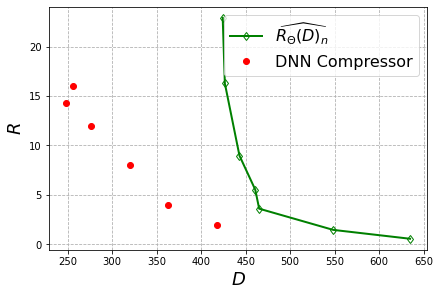

In [22]:
plt.figure(2, constrained_layout=True)
plt.plot(dists_true_rd, rates_true_rd, '-d', color='g', label=r'$\widehat{R_\Theta(D)}_n$', fillstyle='none', linewidth=2)
plt.plot(np.array(d_DNN[:])/3, r_DNN[:], 'o', color='r',label='DNN Compressor')
# plt.plot(rates_ba, dists_ba, '-*', label='Blahut-Arimoto')
plt.ylabel(r'$R$', fontsize=18)
plt.xlabel(r'$D$', fontsize=18)
plt.legend(fontsize=16)
plt.grid(linestyle='dashed')
# plt.xlim([min(dists_true_rd)-2, 64])
# plt.ylim([-0.3, 13])
# plt.savefig('plots/RD_minmax_mnist_RD_sinkhorn.pdf')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


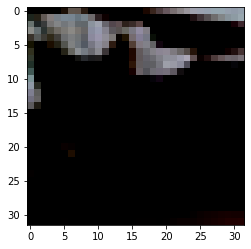

In [21]:
plt.imshow(x[3].cpu().permute(1,2,0))